In [1]:
# https://www.kaggle.com/code/parulpandey/getting-started-with-nlp-a-general-intro/notebook

# 1. Import Libraries

In [2]:
import numpy as np
import pandas as pd

import re 
import string
import nltk
from nltk.corpus import stopwords

import xgboost
from xgboost import XGBClassifier

from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RandomizedSearchCV

# 2. Read Datasets

In [3]:
# Training data
df = pd.read_csv('train.csv')
# Test data
test = pd.read_csv('test.csv')

In [4]:
print(df.shape)
df.head()

(7613, 5)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
print(test.shape)
test.head()

(3263, 4)


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


# 3. EDA

In [6]:
df.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [7]:
test.isna().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

<IPython.core.display.Javascript object>

/Users/trevorban/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:ylabel='target'>

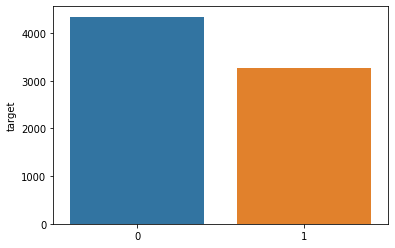

In [8]:
# Target:
# 0 = non-disaster
# 1 = disaster
# A mostly balanced dataset
sns.barplot(df['target'].value_counts().index, df['target'].value_counts())

In [9]:
# Example of a disaster tweet
df[df['target']==1]['text'].values[2]

"All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected"

In [10]:
# Example of a non-disaster tweet
df[df['target']==0]['text'].values[2]

'Summer is lovely'

In [11]:
# Explore keword column for non-disaster
# oddly enough, we get plenty of negative words in the non-disaster set
df[df['target']==0]['keyword'].value_counts()[:10]

body%20bags    40
armageddon     37
harm           37
deluge         36
wrecked        36
ruin           36
explode        35
fear           35
twister        35
siren          35
Name: keyword, dtype: int64

In [12]:
# Explore keword column for non-disaster
df[df['target']==1]['keyword'].value_counts()[:10]

derailment           39
outbreak             39
wreckage             39
typhoon              37
debris               37
oil%20spill          37
suicide%20bomb       32
suicide%20bombing    32
rescuers             32
evacuated            32
Name: keyword, dtype: int64

In [13]:
# how does "disaster" show up in each category
df.loc[df['text'].str.contains('disaster', na=False, case=False)].target.value_counts()
# more often in the disaster category

1    102
0     40
Name: target, dtype: int64

In [14]:
# What are these non-disaster tweets that contain the word "disaster"?
df.loc[
    (df['text'].str.contains('disaster', na=False, case=False)) & 
    (df['target']==0)
]['text'].values[:5]
# makes sense

array(['I forgot to bring chocolate with me. Major disaster.',
       "I'm a disaster?? https://t.co/VCV73BUaCZ",
       "@LovelyLikeLaura I can see why one of your favorite books is 'Beautiful Disaster' it may now be one of mine??",
       'Beautiful disaster // Jon McLaughlin is such a good song',
       'beautiful disaster https://t.co/qm5Sz0fyU8'], dtype=object)

In [15]:
df['location'].value_counts()

USA                          104
New York                      71
United States                 50
London                        45
Canada                        29
                            ... 
#SOUTHAMPTON ENGLAND           1
Some where                     1
London.                        1
???????, ??'??????             1
Sligo and Galway, Ireland      1
Name: location, Length: 3341, dtype: int64

<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='location'>

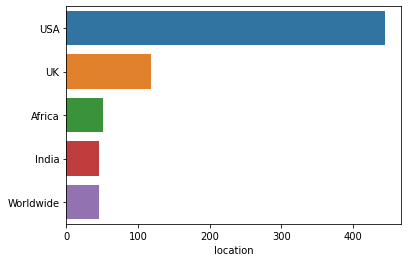

In [16]:
# thanks to https://www.kaggle.com/code/parulpandey/getting-started-with-nlp-a-general-intro/notebook
# Standardize some of the names
df['location'].replace({'United States':'USA',
                           'New York':'USA',
                            "London":'UK',
                            "Los Angeles, CA":'USA',
                            "Washington, D.C.":'USA',
                            "California":'USA',
                             "Chicago, IL":'USA',
                             "Chicago":'USA',
                            "New York, NY":'USA',
                            "California, USA":'USA',
                            "FLorida":'USA',
                            "Nigeria":'Africa',
                            "Kenya":'Africa',
                            "Everywhere":'Worldwide',
                            "San Francisco":'USA',
                            "Florida":'USA',
                            "United Kingdom":'UK',
                            "Los Angeles":'USA',
                            "Toronto":'Canada',
                            "San Francisco, CA":'USA',
                            "NYC":'USA',
                            "Seattle":'USA',
                            "Earth":'Worldwide',
                            "Ireland":'UK',
                            "London, England":'UK',
                            "New York City":'USA',
                            "Texas":'USA',
                            "London, UK":'UK',
                            "Atlanta, GA":'USA',
                            "Mumbai":"India"},inplace=True)

sns.barplot(y=df['location'].value_counts()[:5].index,x=df['location'].value_counts()[:5],
            orient='h')

# 4. Text Preprocessing

### 1. Data Cleaning

In [17]:
df.text[:5]

0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    Just got sent this photo from Ruby #Alaska as ...
Name: text, dtype: object

In [18]:
# basic cleaning
def clean_text(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

df['text'] = df['text'].apply(lambda x: clean_text(x))
test['text'] = test['text'].apply(lambda x: clean_text(x))

In [19]:
df.text[:5]

0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3     people receive wildfires evacuation orders in...
4    just got sent this photo from ruby alaska as s...
Name: text, dtype: object

<IPython.core.display.Javascript object>

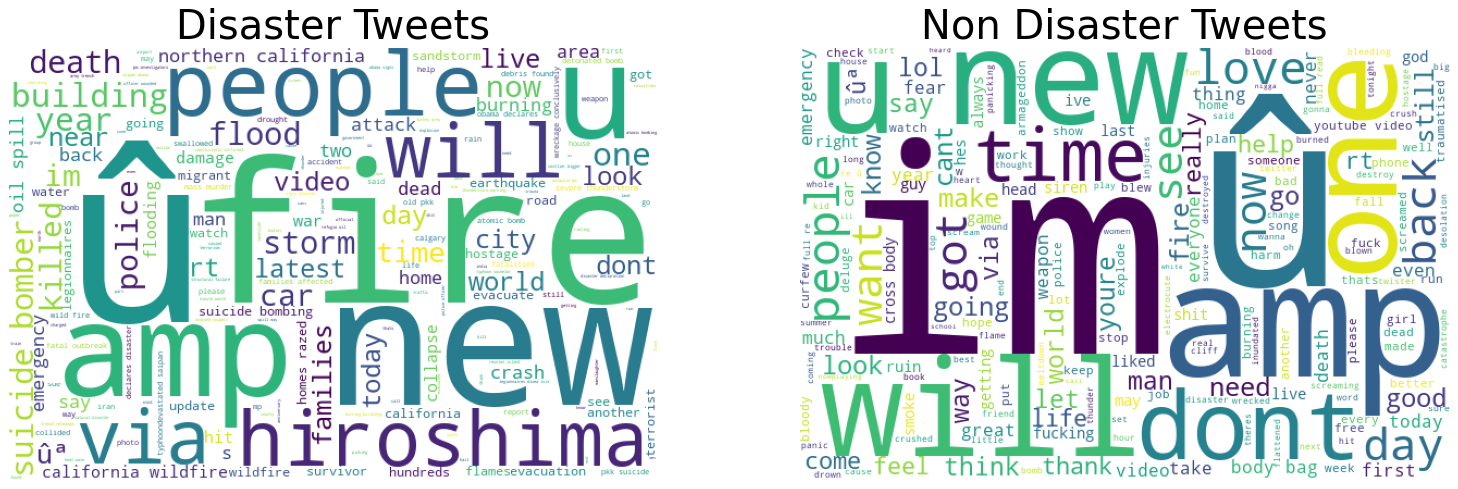

In [20]:
disaster_tweets = df[df['target']==1]['text'].values
non_disaster_tweets = df[df['target']==0]['text'].values

# Build wordcloud for disaster and non disaster tweets
from wordcloud import WordCloud
fig, (ax1, ax2) = plt.subplots(1,2, figsize=[26,8])
wordcloud1 = WordCloud(background_color='white', 
                      width=600, height=400).generate(" ".join(disaster_tweets))
ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Disaster Tweets', fontsize=40)

wordcloud2 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(non_disaster_tweets))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Non Disaster Tweets',fontsize=40);


In [21]:
# odd use of û, will investigate later
df[df['text'].str.contains('û')].head()['text']

38    barbados bridgetown jamaica ûò two cars set a...
52    santa cruz ûó head of the st elizabeth police...
57    set our hearts ablaze and every city was a gif...
71    stlouis caraccidentlawyer speeding among top c...
87    rt naayf first accident in years turning onto ...
Name: text, dtype: object

### 2. stem, lemmatize, stopword removal, tokenization

In [22]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import TreebankWordTokenizer
from nltk.stem import PorterStemmer, WordNetLemmatizer
import string

# initialize
tokenizer = TreebankWordTokenizer()
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# define cleaning/tokenizing function
def clean_tokenize(text):
    # remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # remove numbers
    text = ''.join([i for i in text if not i.isdigit()])
    # convert to lowercase
    text = text.lower()
    # tokenize text
    text = tokenizer.tokenize(text)
    # remove stopwords
    stop_words = set(stopwords.words('english'))
    text = [token for token in text if token not in stop_words]
    # stem
    text = [stemmer.stem(token) for token in text]
    # lemmatize
    text = [lemmatizer.lemmatize(token) for token in text]
    # remove whitespace and non-alphabetic charactesr from tokens
    text = [token.strip() for token in text if token.isalpha()]
    return text

[nltk_data] Downloading package punkt to /Users/trevorban/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/trevorban/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/trevorban/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [23]:
df['text'] = df['text'].apply(clean_tokenize)
test['text'] = test['text'].apply(clean_tokenize)

# 5. transform tokens to vector

In [24]:
# Recombine lists into strings to vectorize
def combine_text(lists):
    combined_text = " ".join(lists)
    return combined_text

df['text'] = df['text'].apply(combine_text)
test['text'] = test['text'].apply(combine_text)

In [25]:
# bag of words method
count_vectorizer = CountVectorizer()
df_v = count_vectorizer.fit_transform(df['text'])
test_v = count_vectorizer.transform(test['text'])

In [26]:
df_v[0].todense()

matrix([[0, 0, 0, ..., 0, 0, 0]])

In [27]:
# tfidf method
tfidf = TfidfVectorizer(min_df = 2, max_df=0.5, ngram_range=(1,2))
df_tfidf = tfidf.fit_transform(df['text'])
test_tfidf = tfidf.transform(test['text'])

In [28]:
df_tfidf[0].todense().shape

(1, 10186)

# 6. Build a Text Classification Model

### Logistic Regression

In [29]:
clf = LogisticRegression()

In [30]:
clf.fit(df_v, df['target'])
clf.score(df_v, df['target'])

0.9477210035465651

In [31]:
model_selection.cross_val_score(clf, df_v, df['target'], 
                                cv=5, scoring='f1')

array([0.58333333, 0.5487013 , 0.61265432, 0.55822551, 0.6962728 ])

In [32]:
clf_tfidf = LogisticRegression()
clf_tfidf.fit(df_tfidf, df['target'])
clf_tfidf.score(df_tfidf, df['target'])

0.8766583475633785

In [33]:
model_selection.cross_val_score(clf_tfidf, df_tfidf, 
                                df['target'], cv=5, scoring='f1')


array([0.57677165, 0.54465075, 0.58664413, 0.44208289, 0.68154506])

### Naive Bayes

In [34]:
clf_NB = MultinomialNB()
clf_NB.fit(df_v, df['target'])
clf_NB.score(df_v, df['target'])

0.9000394062787338

In [35]:
model_selection.cross_val_score(clf_NB, df_v, df['target'], 
                                cv=5, scoring='f1')

array([0.64585045, 0.61813187, 0.66351989, 0.64521193, 0.74140303])

In [36]:
clf_NB = MultinomialNB()
clf_NB.fit(df_tfidf, df['target'])
clf_NB.score(df_tfidf, df['target'])

0.8628661500065677

In [37]:
model_selection.cross_val_score(clf_NB, df_tfidf, df['target'], 
                                cv=5, scoring='f1')

array([0.57142857, 0.5918537 , 0.6411093 , 0.59590317, 0.73158756])

### XGBoost

In [38]:
import xgboost as xgb
clf_xgb = xgb.XGBClassifier(max_depth=7, n_estimators=200, 
                           colsample_bytree=0.8, subsample=0.8, 
                           nthread=10, learning_rate=0.1)
clf_xgb.fit(df_v, df['target'])
clf_xgb.score(df_v, df['target'])

/Users/trevorban/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:57:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.8239852883226061

In [39]:
model_selection.cross_val_score(clf_xgb, df_v, df['target'], 
                                cv=5, scoring='f1')


/Users/trevorban/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:57:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/trevorban/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:57:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/trevorban/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:57:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/trevorban/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:58:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/trevorban/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:58:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


array([0.49742002, 0.39338235, 0.53617669, 0.37820513, 0.58855098])

In [40]:
clf_xgb_tfidf = xgb.XGBClassifier(max_depth=7, n_estimators=200, 
                           colsample_bytree=0.8, subsample=0.8, 
                           nthread=10, learning_rate=0.1)
clf_xgb_tfidf.fit(df_tfidf, df['target'])
clf_xgb_tfidf.score(df_tfidf, df['target'])

/Users/trevorban/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:59:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.8434257191645869

In [41]:
model_selection.cross_val_score(clf_xgb_tfidf, df_tfidf, df['target'], 
                                cv=5, scoring='f1')

/Users/trevorban/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:00:07] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/trevorban/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:00:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/trevorban/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:00:18] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/trevorban/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:00:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/trevorban/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:00:30] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


array([0.50263992, 0.39122137, 0.49427169, 0.37796976, 0.57090909])

# Putting it all together

In [63]:
# Test each model on cross eval and accuracy
def score_models_w_wo_tfidf(models, dic):
    from statistics import mean
    import warnings
    warnings.filterwarnings("ignore")  # don't judge me 
    
    for model in models:
        model.fit(df_v, df['target'])
        score = model.score(df_v, df['target'])
        cross_val = model_selection.cross_val_score(model, df_v, df['target'], 
                                cv=5, scoring='f1')
        
        model.fit(df_tfidf, df['target'])
        tfidf_score = model.score(df_tfidf, df['target'])
        tfidf_cross_val = model_selection.cross_val_score(model, df_tfidf, df['target'], 
                                cv=5, scoring='f1')
        print("Score for {}".format(type(model).__name__))
        print("Vector score: {} \nTFIDF score {}".format(score, tfidf_score))
        print("Vector cross_eval: {} \nTFIDF cross_eval: {} \n".format(mean(cross_val), mean(tfidf_cross_val)))
        
        dic[type(model).__name__] = [score, tfidf_score, mean(cross_val), mean(tfidf_cross_val)]

In [64]:
clf = LogisticRegression()
clf_NB = MultinomialNB()
clf_xgb = xgb.XGBClassifier(max_depth=7, n_estimators=200, 
                           colsample_bytree=0.8, subsample=0.8, 
                           nthread=10, learning_rate=0.1, eval_metric='logloss')

dic_ = {}

score_models_w_wo_tfidf([clf, clf_NB, clf_xgb], dic_)

Score for LogisticRegression
Vector score: 0.9477210035465651 
TFIDF score 0.8766583475633785
Vector cross_eval: 0.5998374521411598 
TFIDF cross_eval: 0.5663388970231866 

Score for MultinomialNB
Vector score: 0.9000394062787338 
TFIDF score 0.8628661500065677
Vector cross_eval: 0.6628234338468899 
TFIDF cross_eval: 0.6263764592312729 

Score for XGBClassifier
Vector score: 0.8239852883226061 
TFIDF score 0.8434257191645869
Vector cross_eval: 0.47874703605569935 
TFIDF cross_eval: 0.46740236573152993 



In [65]:
dic_

{'LogisticRegression': [0.9477210035465651,
  0.8766583475633785,
  0.5998374521411598,
  0.5663388970231866],
 'MultinomialNB': [0.9000394062787338,
  0.8628661500065677,
  0.6628234338468899,
  0.6263764592312729],
 'XGBClassifier': [0.8239852883226061,
  0.8434257191645869,
  0.47874703605569935,
  0.46740236573152993]}

#### The highest Cross Eval score was for MultinomialNB without tfidf.  In almost every case, tfidf made the model worse.  Congrats Naive Bayes